<a href="https://colab.research.google.com/github/alxkzncoff/skillfactory_rds6_car_price_prediction_ml_dl/blob/main/model/dense_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q tensorflow==2.3

In [4]:
!mkdir work_dir

# DEFINE

In [3]:
DATA_PATH                           = '/content/work_dir'
RANDOM_SEED                         = 42

# IMPORT

In [13]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import PIL
import cv2
import re

# ml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import lognorm
from scipy.stats import shapiro

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [153]:
train = pd.read_csv(DATA_PATH+'/clear_train.csv')
test = pd.read_csv(DATA_PATH+'/clear_test.csv')

# PREPARING

In [154]:
df = pd.concat([train, test])

(array([ 100.,    0.,  449., 1091.,  600., 2075., 2195., 1460.,  310.,
          73.]),
 array([5.7235851 , 6.10722063, 6.49085615, 6.87449168, 7.2581272 ,
        7.64176272, 8.02539825, 8.40903377, 8.7926693 , 9.17630482,
        9.55994035]),
 <a list of 10 Patch objects>)

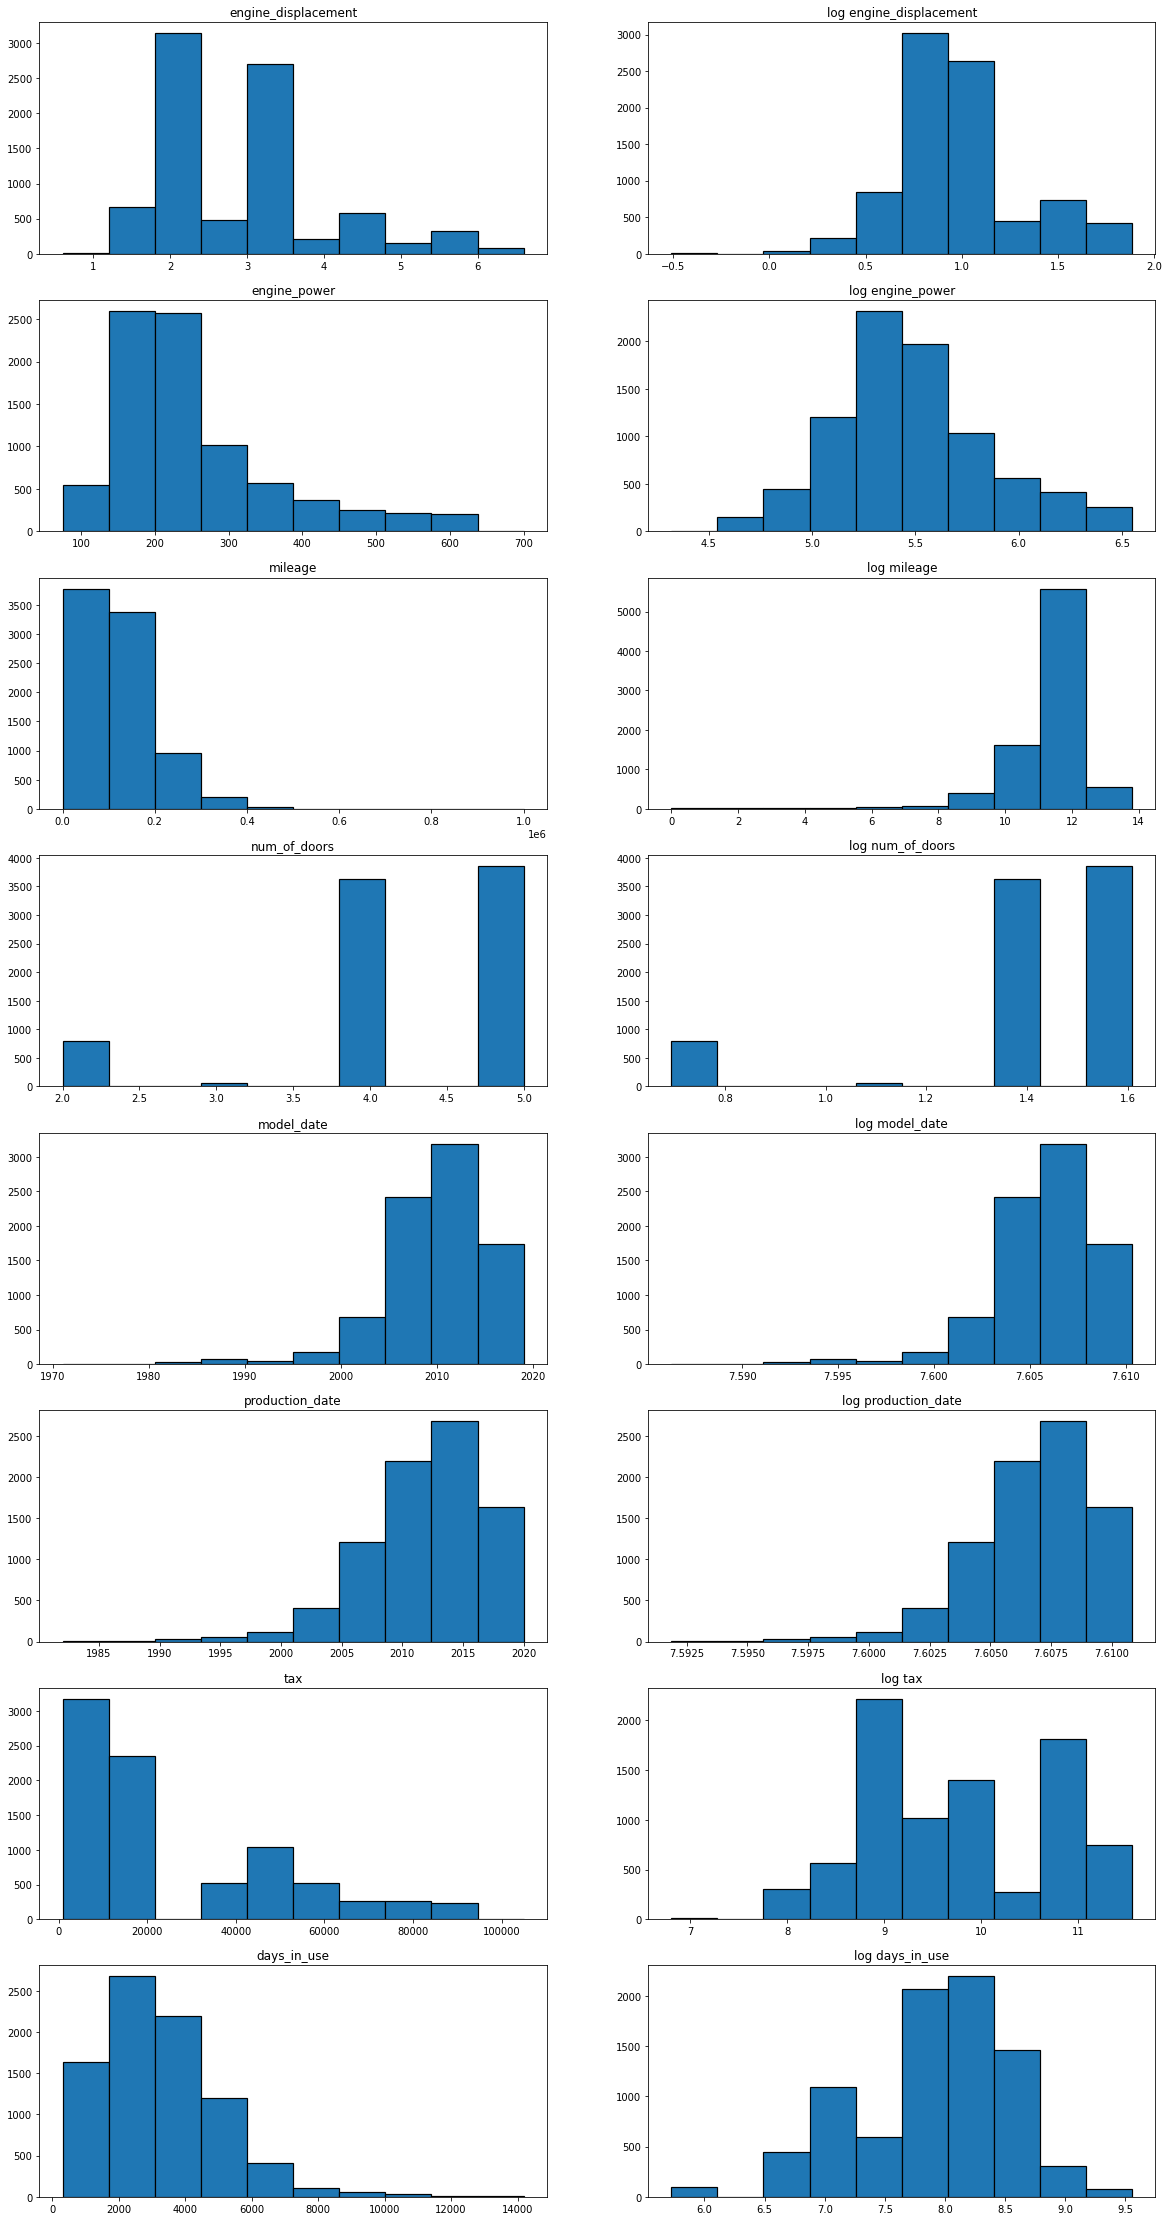

In [155]:
fig, ax = plt.subplots(8,2, figsize=(20,40))

# ####################### engine_displacement ############################
ax[0,0].set_title('engine_displacement')
ax[0,0].hist(df['engine_displacement'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[0,1].set_title('log engine_displacement')
ax[0,1].hist(np.log(df['engine_displacement']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### engine_power ############################
ax[1,0].set_title('engine_power')
ax[1,0].hist(df['engine_power'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[1,1].set_title('log engine_power')
ax[1,1].hist(np.log(df['engine_power']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### mileage ############################
ax[2,0].set_title('mileage')
ax[2,0].hist(df['mileage'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[2,1].set_title('log mileage')
ax[2,1].hist(np.log(df['mileage']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### num_of_doors ############################
ax[3,0].set_title('num_of_doors')
ax[3,0].hist(df['num_of_doors'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[3,1].set_title('log num_of_doors')
ax[3,1].hist(np.log(df['num_of_doors']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### model_date ############################
ax[4,0].set_title('model_date')
ax[4,0].hist(df['model_date'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[4,1].set_title('log model_date')
ax[4,1].hist(np.log(df['model_date']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### production_date ############################
ax[5,0].set_title('production_date')
ax[5,0].hist(df['production_date'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[5,1].set_title('log production_date')
ax[5,1].hist(np.log(df['production_date']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### tax ############################
ax[6,0].set_title('tax')
ax[6,0].hist(df['tax'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[6,1].set_title('log tax')
ax[6,1].hist(np.log(df['tax']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### days_in_use ############################
ax[7,0].set_title('days_in_use')
ax[7,0].hist(df['days_in_use'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[7,1].set_title('log days_in_use')
ax[7,1].hist(np.log(df['days_in_use']), bins=10, edgecolor='black' ,linewidth=1.2)

In [156]:
df.price.fillna(0, inplace=True)
df['sample'] = df.price.apply(lambda x:0 if x == 0 else 1)

In [122]:
# ##################### Логорифмируем ######################
# df.engine_displacement = np.log(df.engine_displacement)
# df.engine_power = np.log(df.engine_power)
# df.mileage = np.log(df.mileage)
# df.model_date = np.log(df.model_date)
# df.production_date = np.log(df.production_date)
# df.num_of_doors = np.log(df.num_of_doors)
# df.tax = np.log(df.tax)
# df.days_in_use = np.log(df.days_in_use)

In [157]:
def data_prep(df):

  categorical_features = ['body', 'brand', 'color', 'fuel', 'model_info', 'name', 'transmission', 'owners', 'vehicle_title', 'drive_type']
  numerical_features = ['engine_displacement', 'engine_power', 'mileage', 'num_of_doors', 'model_date', 'production_date', 'tax', 'days_in_use']

  # ############################## Label Encoding #####################################
  for column in categorical_features:
      df[column] = df[column].astype('category').cat.codes
  
  # ############################### One Hot encoding ###################################
  df = pd.get_dummies(df, columns=categorical_features, dummy_na=False)

  # ############################### Normalization ######################################
  MMS = MinMaxScaler()

  MMS.fit(df[numerical_features])
  df[numerical_features] = MMS.transform(df[numerical_features])

  return df

In [158]:
df = data_prep(df)
df.shape

(8353, 542)

# SPLIT

In [159]:
X = df.query('sample==1').drop(columns=['description', 'price', 'sample'])
y = df.query('sample==1').price.values
test = df.query('sample==0').drop(columns=['price', 'sample'])

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

# MODEL

In [161]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [162]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [163]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               276480    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 408,065
Trainable params: 408,065
Non-trainable params: 0
_________________________________________________________________


In [164]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [165]:
checkpoint = ModelCheckpoint(DATA_PATH+'/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [166]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0
                   )

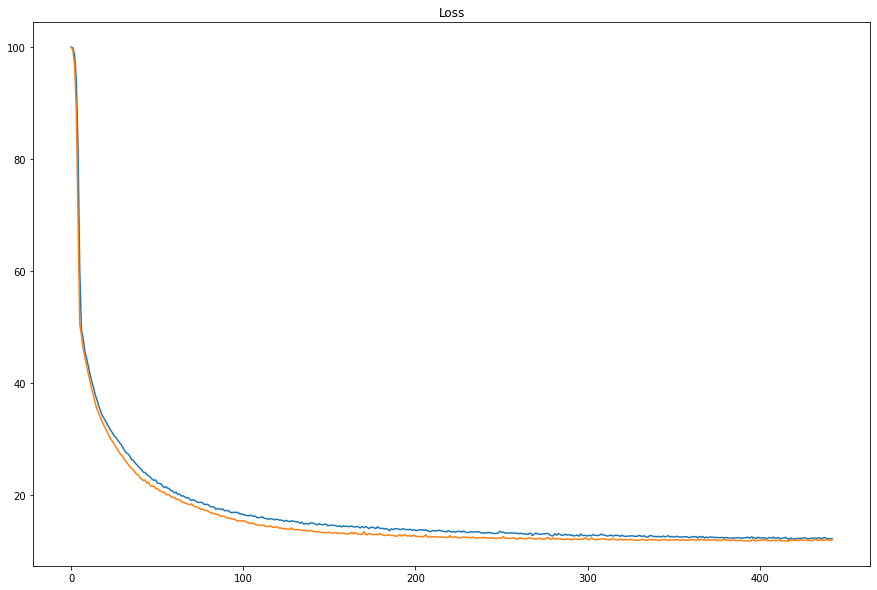

In [167]:
plt.figure(figsize=(15,10))
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [168]:
model.load_weights(DATA_PATH+'/best_model.hdf5')
model.save(DATA_PATH+'/nn_1.hdf5')

In [169]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.89%


Попробовал прологорифмировать числовые признаки, результат модели ухудшился до **12.91%**. Оставил как есть.
